<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/adm0/pillar2_processing_adm0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install rasterio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 111.7 MB/s eta 0:00:00


In [14]:
import pandas as pd
import glob
import os
import shutil
import warnings
import seaborn as sns
import numpy as np
from scipy.stats import gmean
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler

In [5]:
#define function to remove outliers and find min max values to reduce skew
def trim_outliers_iteratively(values, max_skew=2, max_kurtosis=3.5):
    """
    Iteratively removes extreme min/max values until skewness <= 2 and kurtosis <= 3.5.
    Returns the trimmed dataset along with the final min and max.
    """
    values = values.dropna().values  # Ensure no NaNs
    while True:
        current_skew = skew(values)
        current_kurtosis = kurtosis(values)

        if abs(current_skew) <= max_skew and current_kurtosis <= max_kurtosis:
            break  # Stop if conditions are met

        # Remove min and max values
        min_val, max_val = values.min(), values.max()
        values = values[(values > min_val) & (values < max_val)]  # Trim extreme min/max

    return values, values.min(), values.max()

In [6]:
def boxplot_outlier_detection(values):
    """
    Detect outliers using the IQR method (1.5 IQR rule).
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return values that are within bounds
    return values[(values >= lower_bound) & (values <= upper_bound)], lower_bound, upper_bound

plot distribution and skewness information to select min max values

processed : P2_WASH_Drinking_Water min: 35.11656657990258 max: 100.0
P2_WASH_Drinking_Water: skew=-1.795, kurtosis=2.417
IQR processed : P2_WASH_Drinking_Water min: 69.47570068944626 max: 118.0565895654253


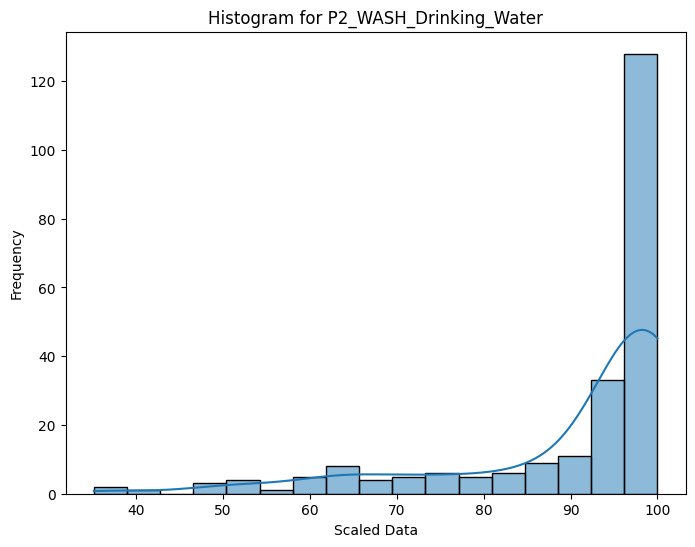

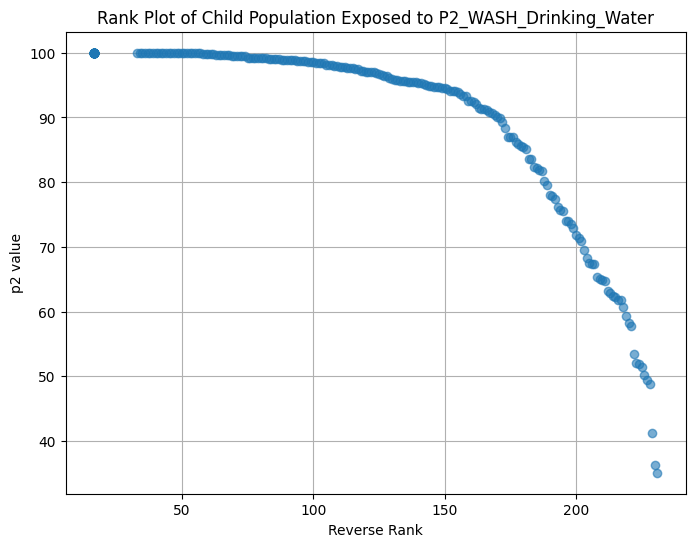

processed : P2_WASH_Sanitation min: 9.336216099 max: 100.0
P2_WASH_Sanitation: skew=-1.343, kurtosis=0.455
IQR processed : P2_WASH_Sanitation min: 27.104962747500018 max: 142.1499890475


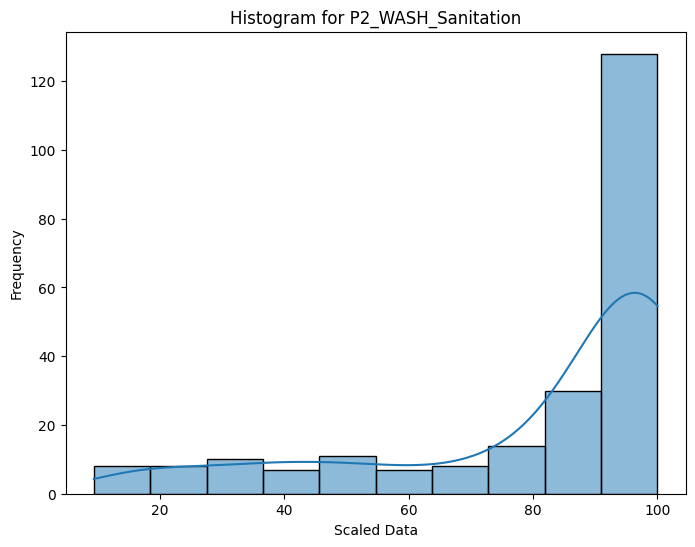

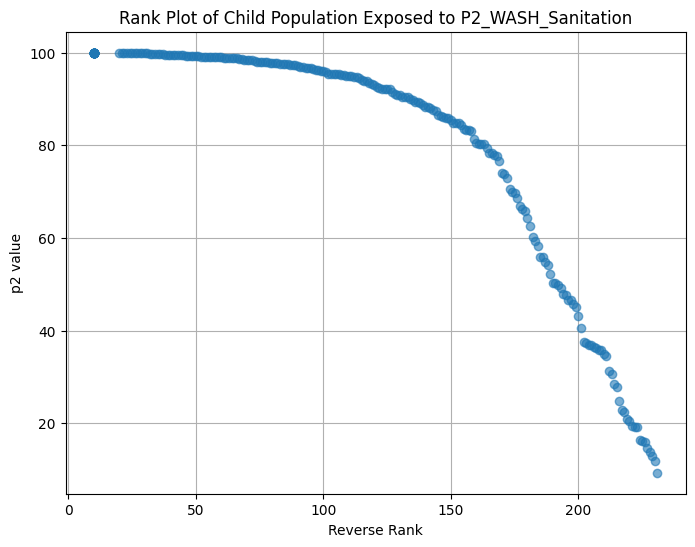

processed : P2_LSCED min: 0.0267945 max: 72.58609
P2_LSCED: skew=1.529, kurtosis=1.657
IQR processed : P2_LSCED min: -28.835547375 max: 55.651320424999994


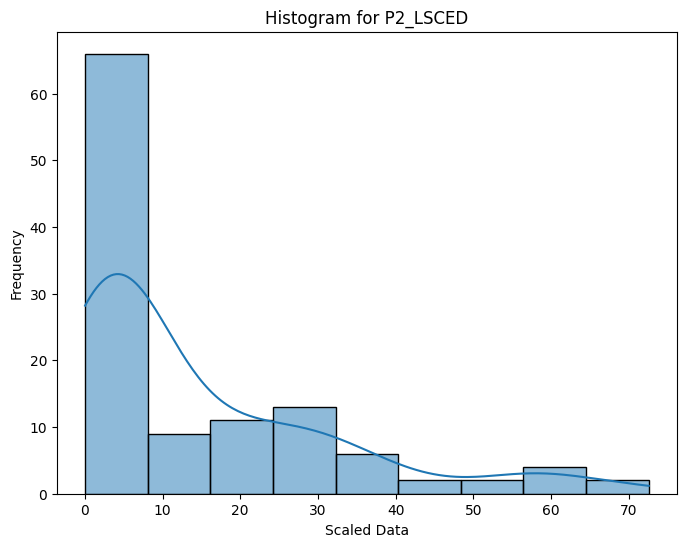

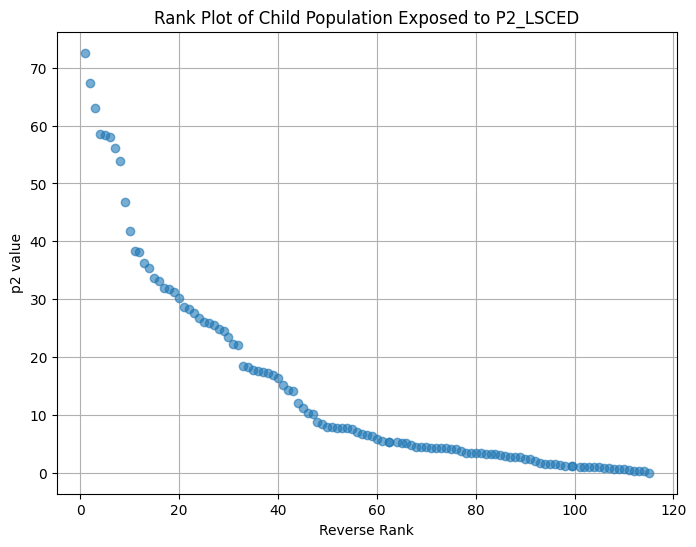

processed : P2_Nutrition_Stunting_Modeled min: 1.2 max: 56.5
P2_Nutrition_Stunting_Modeled: skew=0.918, kurtosis=0.158
IQR processed : P2_Nutrition_Stunting_Modeled min: -21.549999999999997 max: 54.05


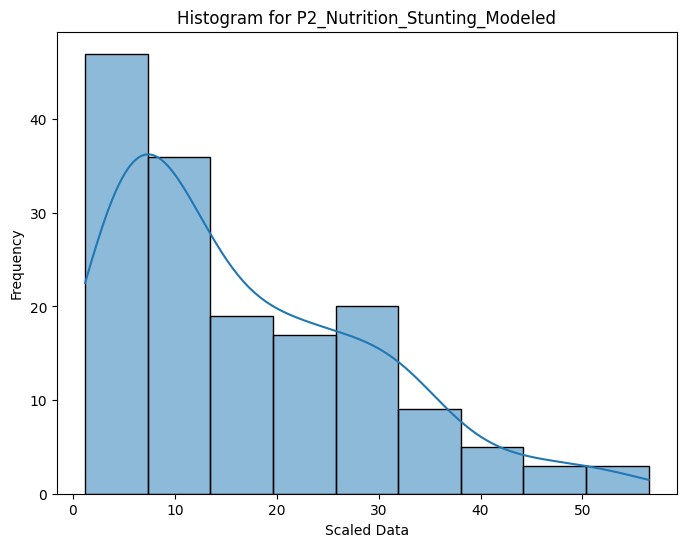

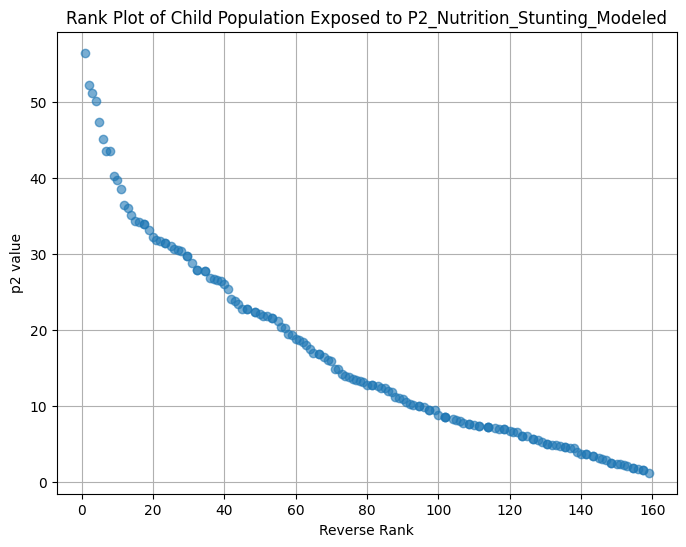

processed : P2_Child_Mortality min: 0.404633951697431 max: 30.2232985695993
P2_Child_Mortality: skew=1.931, kurtosis=3.232
IQR processed : P2_Child_Mortality min: -9.678824074735205 max: 18.43642556071666


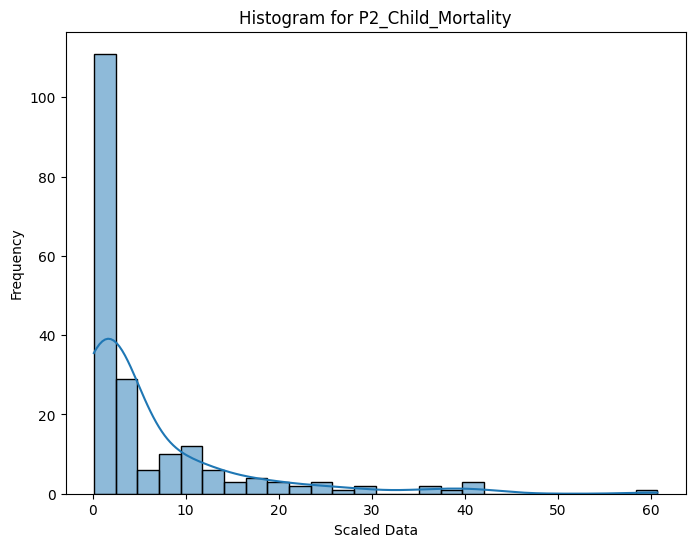

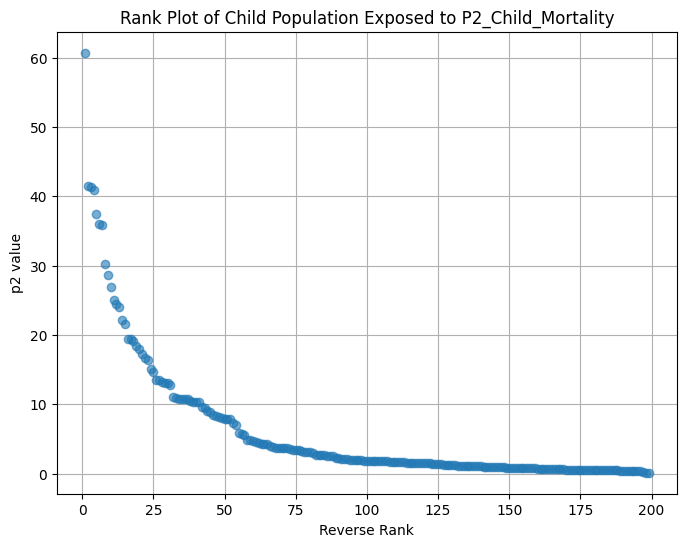

processed : P2_Immunization_DTP1 min: 45.0 max: 98.0
P2_Immunization_DTP1: skew=-1.564, kurtosis=2.334
IQR processed : P2_Immunization_DTP1 min: 72.25 max: 114.25


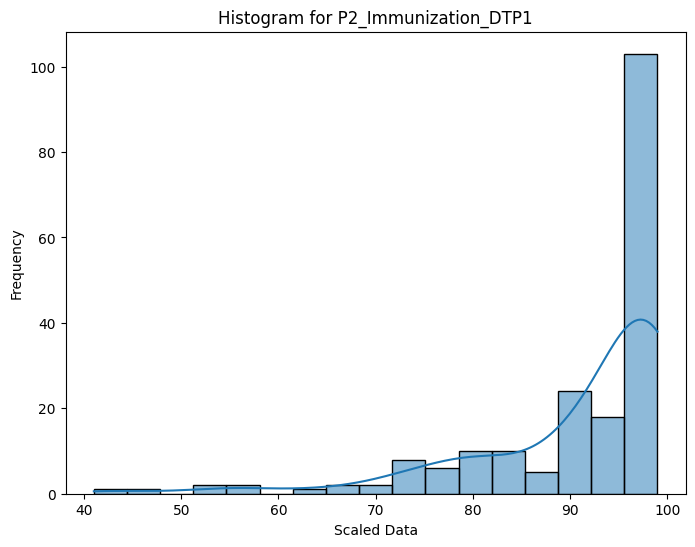

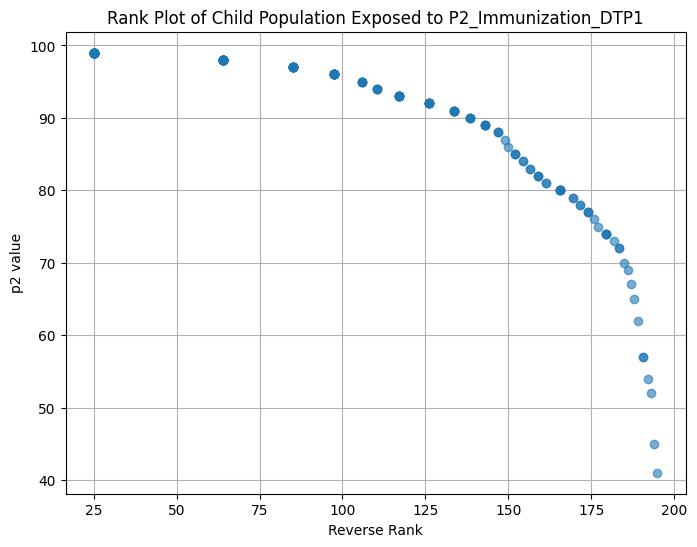

processed : P2_Immunization_DTP3 min: 35.0 max: 98.0
P2_Immunization_DTP3: skew=-1.409, kurtosis=1.593
IQR processed : P2_Immunization_DTP3 min: 59.75 max: 117.75


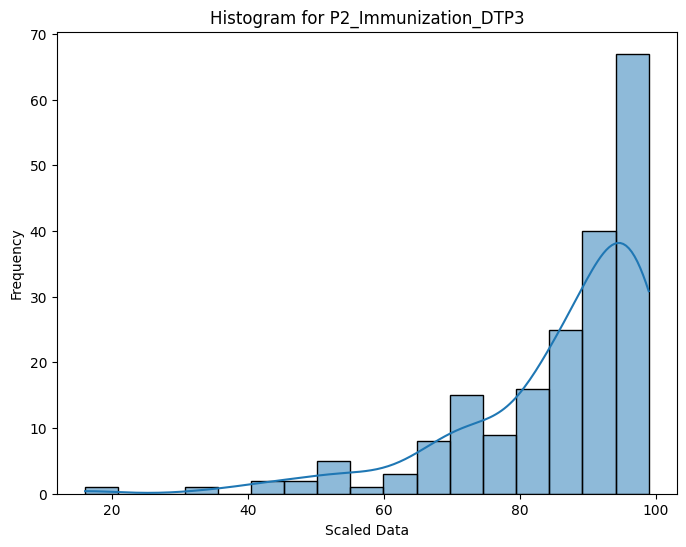

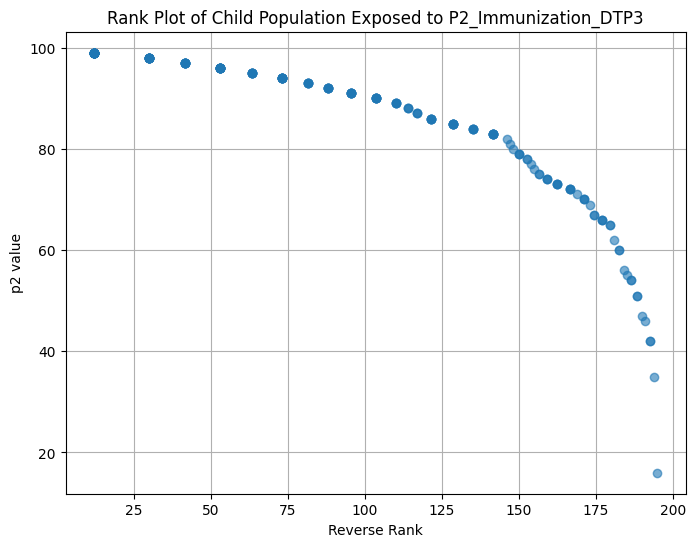

processed : P2_PT_Labor min: 0.3 max: 41.5
P2_PT_Labor: skew=0.763, kurtosis=-0.118
IQR processed : P2_PT_Labor min: -19.400000000000002 max: 43.800000000000004


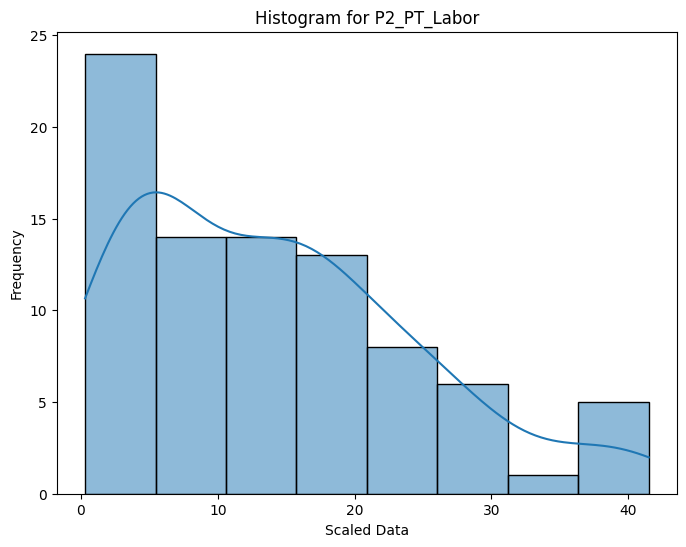

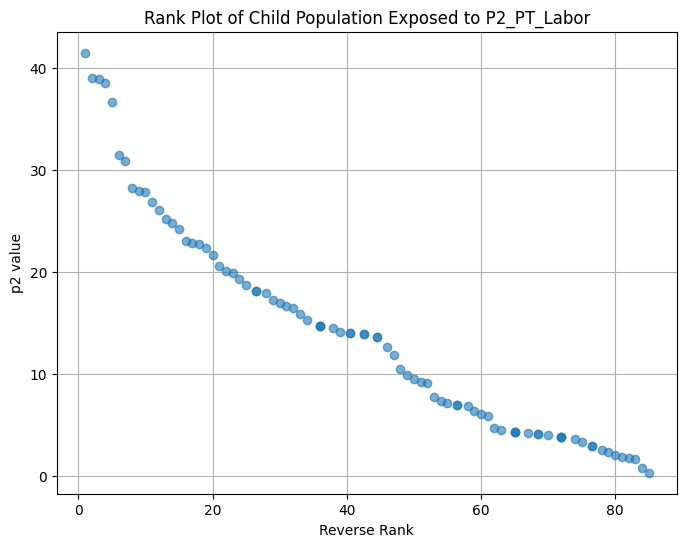

processed : P2_Learning_Poverty min: 2.330512762069702 max: 98.50421142578124
P2_Learning_Poverty: skew=0.316, kurtosis=-1.407
IQR processed : P2_Learning_Poverty min: -88.06367611885071 max: 174.0795295238495


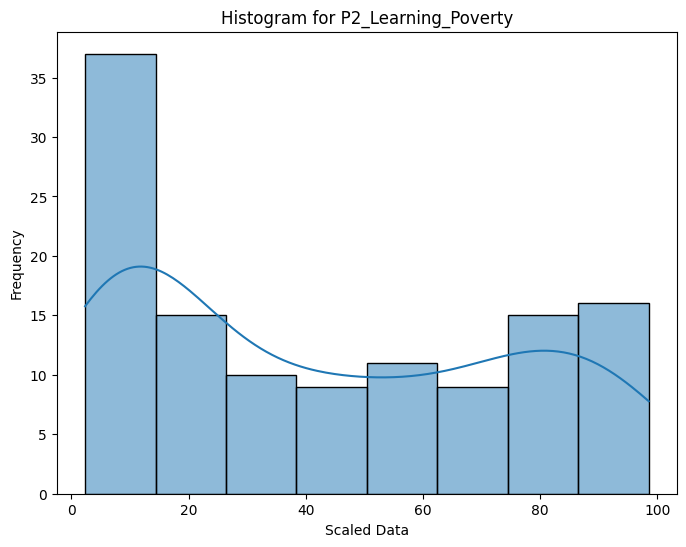

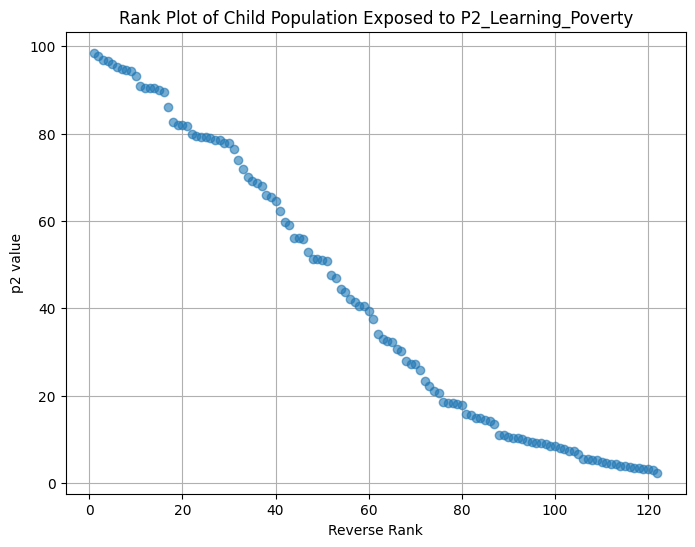

processed : P2_ED_CR_L2 min: 5.8079791 max: 99.800003
P2_ED_CR_L2: skew=-0.329, kurtosis=-1.172
IQR processed : P2_ED_CR_L2 min: -22.357141999999996 max: 156.077902


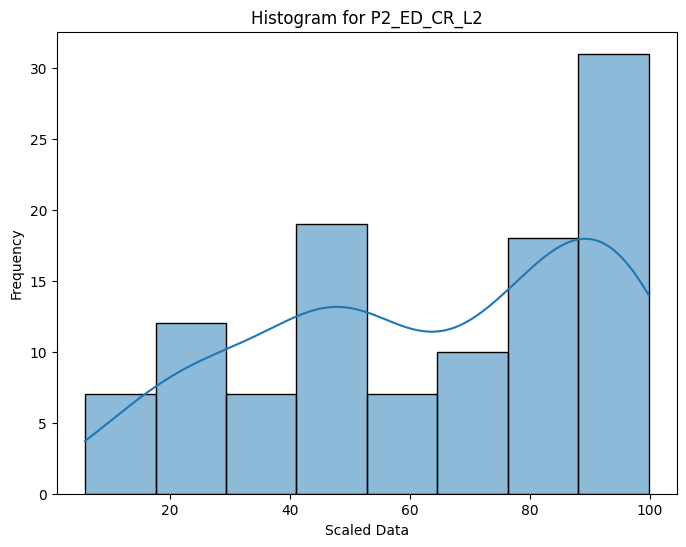

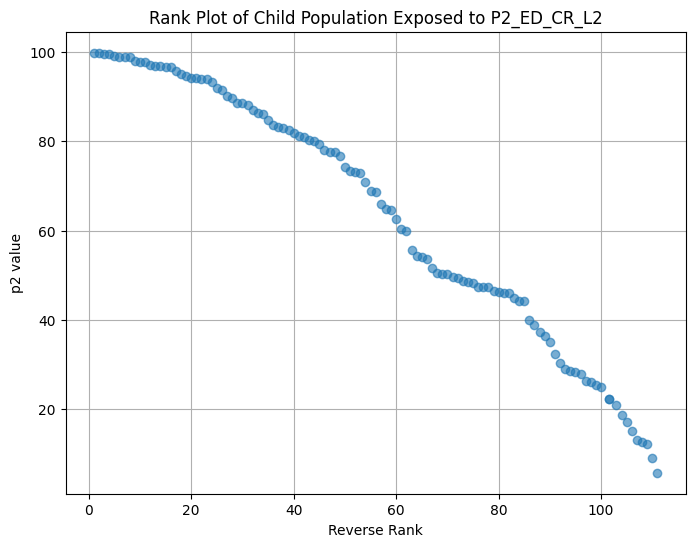

processed : P2_Birth_Attendant_Y15T19 min: 25.4 max: 100.0
P2_Birth_Attendant_Y15T19: skew=-1.468, kurtosis=1.136
IQR processed : P2_Birth_Attendant_Y15T19 min: 46.22500000000002 max: 130.02499999999998


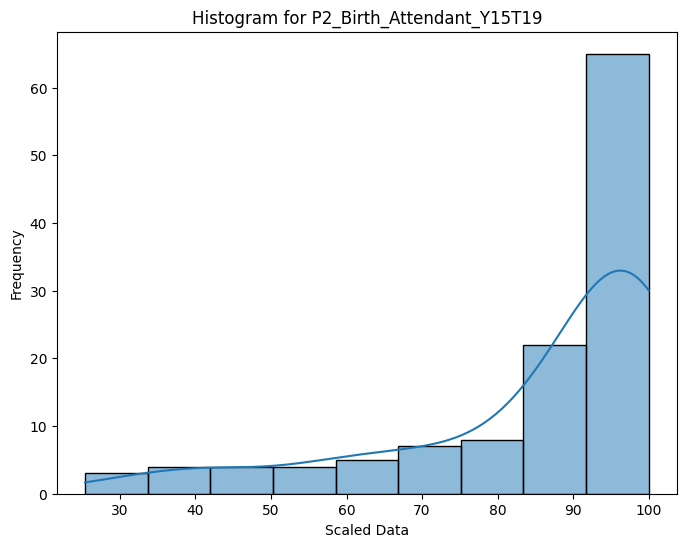

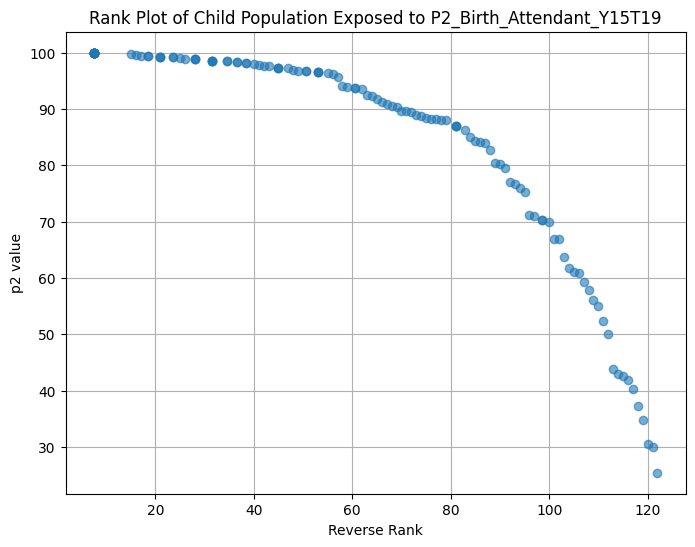

processed : P2_Child_poverty min: 2.6400771141052246 max: 83.46825408935547
P2_Child_poverty: skew=0.289, kurtosis=-0.795
IQR processed : P2_Child_poverty min: -29.098213195800792 max: 98.61497497558594


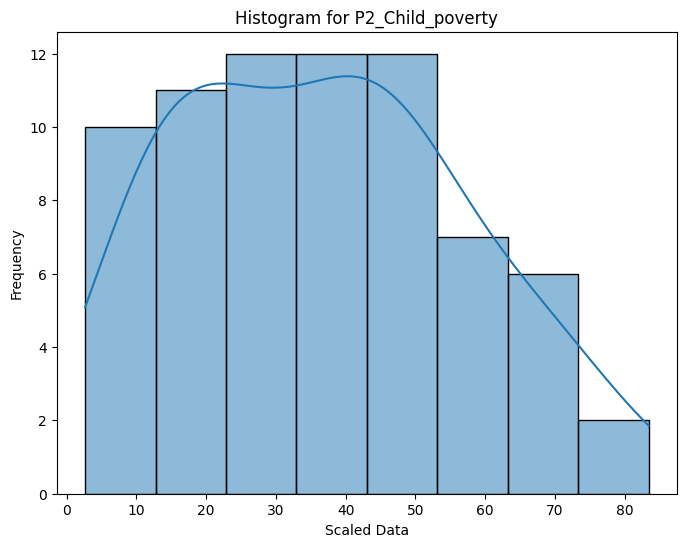

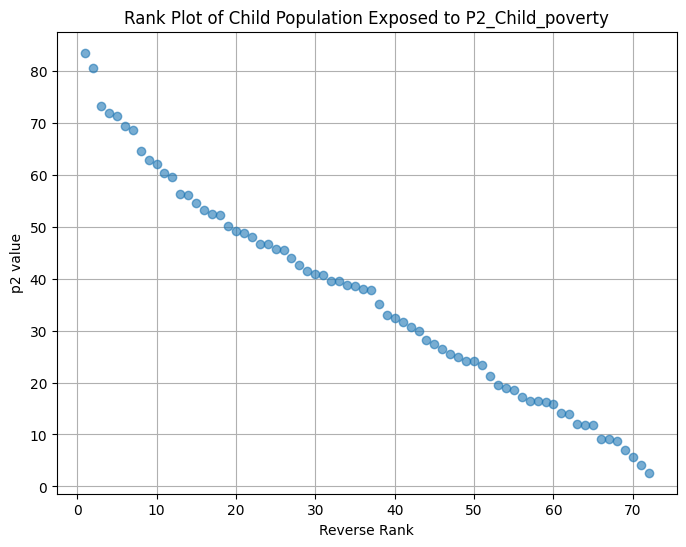

processed : P2_Child_Marriage min: 0.0 max: 76.3
P2_Child_Marriage: skew=0.875, kurtosis=0.918
IQR processed : P2_Child_Marriage min: -24.374999999999996 max: 61.425


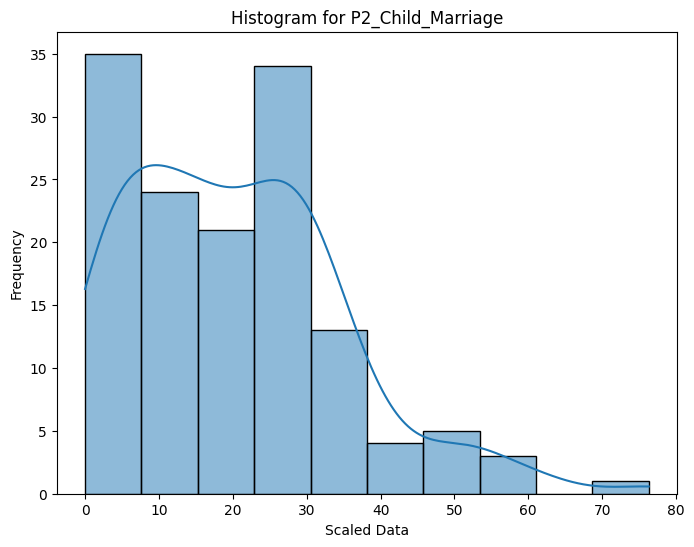

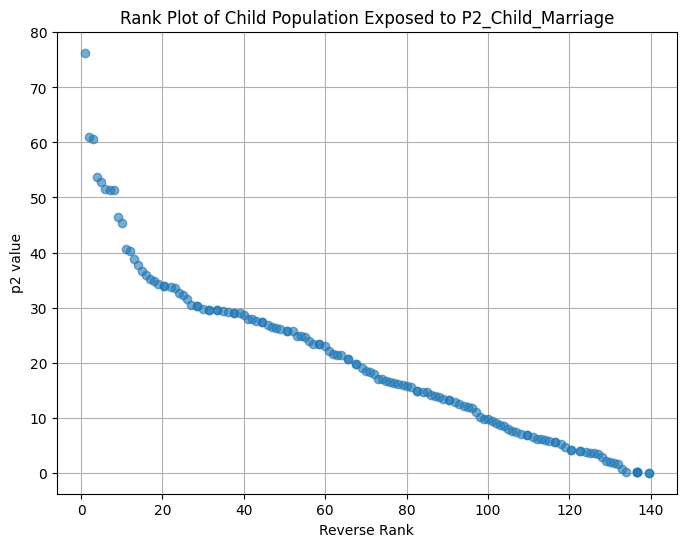

processed : P2_food_poverty min: 0.0 max: 70.1
P2_food_poverty: skew=0.845, kurtosis=0.224
IQR processed : P2_food_poverty min: -27.449999999999996 max: 65.14999999999999


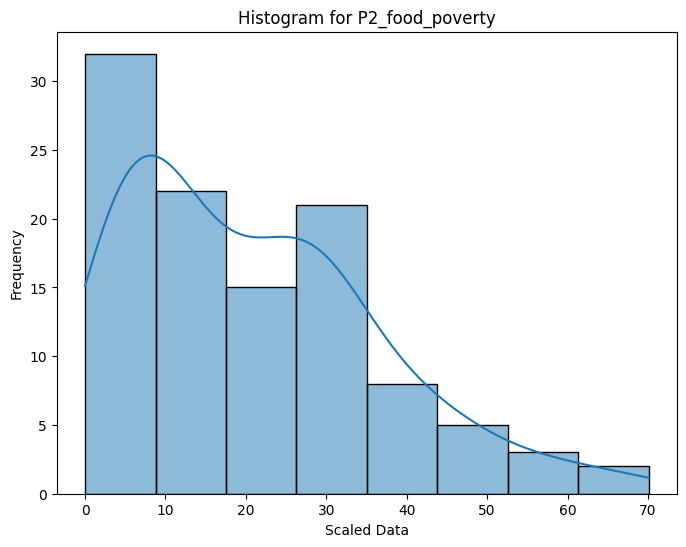

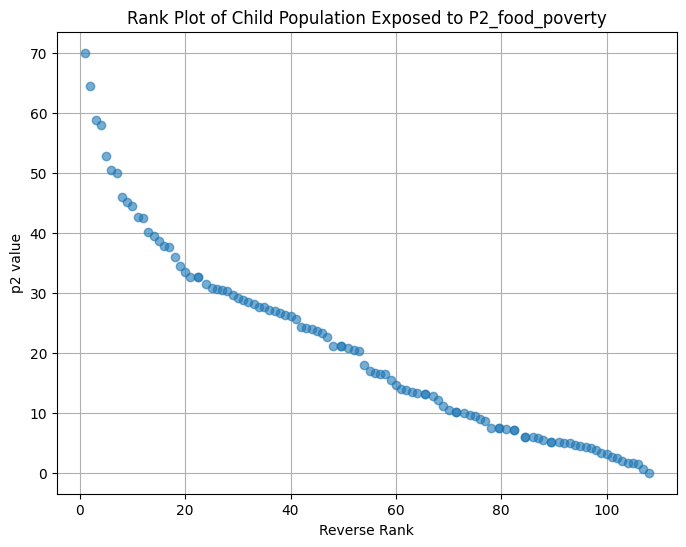

processed : P2_Social_Protection min: 0.0 max: 100.0
P2_Social_Protection: skew=0.690, kurtosis=-1.067
IQR processed : P2_Social_Protection min: -86.37500000000001 max: 158.425


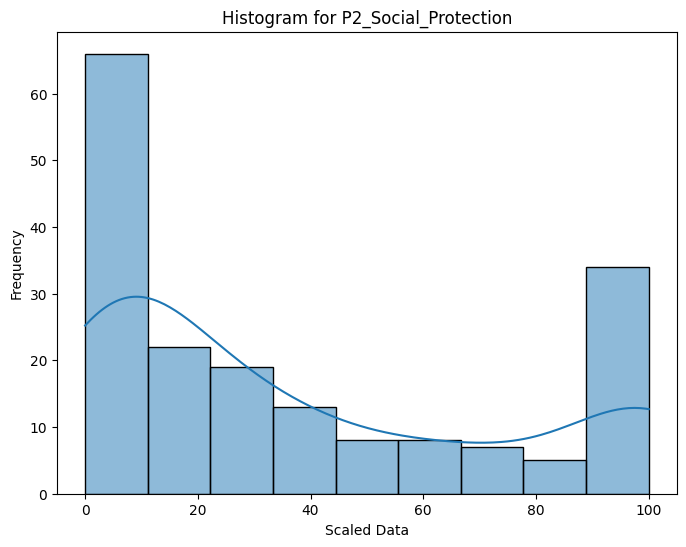

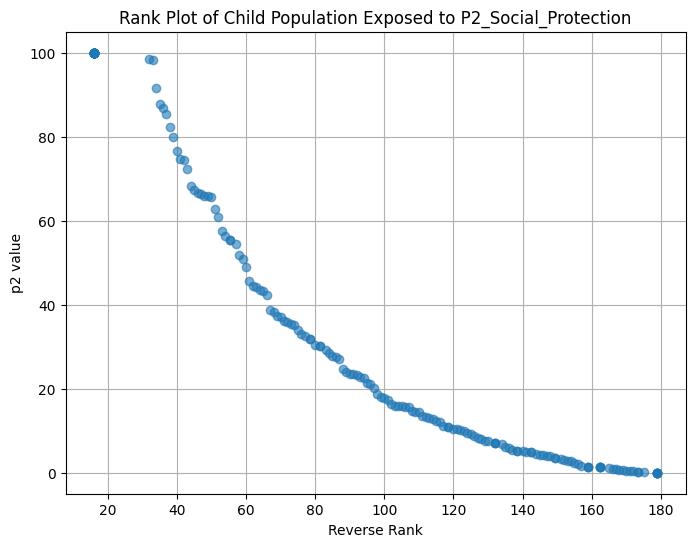

processed : P2_basic_hygiene min: 3.440188936 max: 100.0
P2_basic_hygiene: skew=-0.252, kurtosis=-1.536
IQR processed : P2_basic_hygiene min: -68.98053082125001 max: 181.57403580875


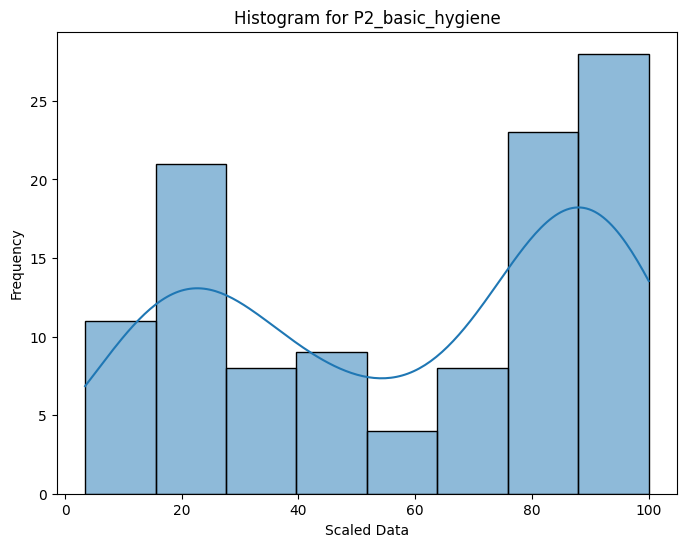

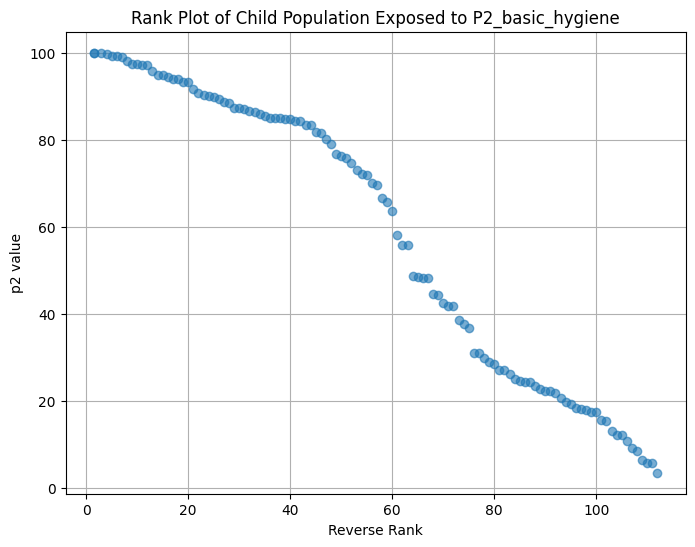

processed : P2_electricity_access min: 9.3 max: 100.0
P2_electricity_access: skew=-1.627, kurtosis=1.252
IQR processed : P2_electricity_access min: 58.722925000000004 max: 124.766245


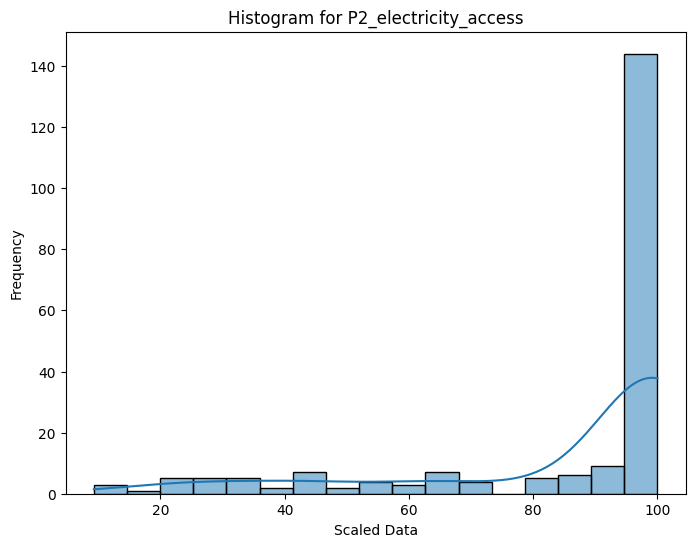

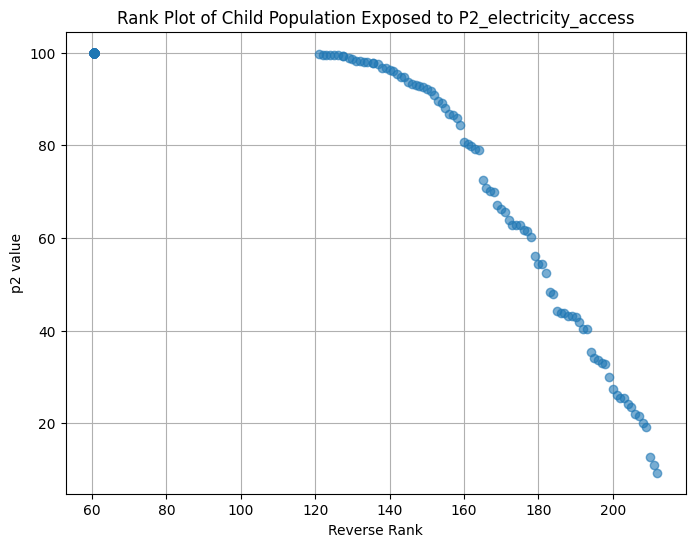

In [ ]:
# Define source and destination folder paths
source_folder = "/content/drive/MyDrive/p2_vulnerability/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

# List of variables to reverse normalize
reverse_columns = [
    'P2_LSCED',
    'P2_Birth_Attendant_Y15T19',
    'P2_ED_CR_L2',
    'P2_Immunization_DTP1',
    'P2_Immunization_DTP3',
    'P2_WASH_Drinking_Water',
    'P2_WASH_Sanitation',
    'P2_basic_hygiene',
    'P2_electricity_access',
    'P2_Social_Protection'
]

# Initialize an empty DataFrame for merged results
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)

    if 'iso3' not in df.columns or 'value' not in df.columns:
        continue  # Skip files missing required columns
    # Normalize 'value' column
    df = df[['iso3', 'value']].dropna()
    # Apply iterative trimming
    trimmed_values, min_trimmed, max_trimmed = trim_outliers_iteratively(df['value'])
    iqr_trimmed_values, iqr_lower_bound, iqr_upper_bound = boxplot_outlier_detection(df['value'])

    # Extract filename for column naming
    filename = os.path.basename(file).replace(".csv", "")

    print(f"processed : {filename} min: {min_trimmed} max: {max_trimmed}" )
    current_skew = skew(trimmed_values)
    current_kurtosis = kurtosis(trimmed_values)
    print(f"{filename}: skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")
    print(f"IQR processed : {filename} min: {iqr_lower_bound} max: {iqr_upper_bound}" )

    # Plot histogram and normality check
    plt.figure(figsize=(8, 6))
    sns.histplot(df['value'], kde=True)
    plt.title(f"Histogram for {filename}")
    plt.xlabel("Scaled Data")
    plt.ylabel("Frequency")
    plt.show()

    # Compute ranks in reverse order
    df['rank_reverse'] = df['value'].rank(method='average', ascending=False)
    plt.figure(figsize=(8, 6))
    plt.plot(df['rank_reverse'], df['value'], marker='o', linestyle='', alpha=0.6)
    plt.xlabel("Reverse Rank")
    plt.ylabel("p2 value")
    plt.title(f"Rank Plot of Child Population Exposed to {filename}")
    plt.grid(True)
    plt.show()



Normalize and obtain min max value for P2 indicators

In [12]:
# Define source and destination folder paths
source_folder = "/content/drive/MyDrive/p2_vulnerability/"
destination_folder = "/content/drive/MyDrive/CCRI_results_misc/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))
for file in csv_files:
    print(file)

/content/drive/MyDrive/p2_vulnerability/P2_WASH_Drinking_Water.csv
/content/drive/MyDrive/p2_vulnerability/P2_WASH_Sanitation.csv
/content/drive/MyDrive/p2_vulnerability/P2_LSCED.csv
/content/drive/MyDrive/p2_vulnerability/P2_Nutrition_Stunting_Modeled.csv
/content/drive/MyDrive/p2_vulnerability/P2_Child_Mortality.csv
/content/drive/MyDrive/p2_vulnerability/P2_Immunization_DTP1.csv
/content/drive/MyDrive/p2_vulnerability/P2_Immunization_DTP3.csv
/content/drive/MyDrive/p2_vulnerability/P2_PT_Labor.csv
/content/drive/MyDrive/p2_vulnerability/P2_Learning_Poverty.csv
/content/drive/MyDrive/p2_vulnerability/P2_ED_CR_L2.csv
/content/drive/MyDrive/p2_vulnerability/P2_Birth_Attendant_Y15T19.csv
/content/drive/MyDrive/p2_vulnerability/P2_Child_poverty.csv
/content/drive/MyDrive/p2_vulnerability/P2_Child_Marriage.csv
/content/drive/MyDrive/p2_vulnerability/P2_food_poverty.csv
/content/drive/MyDrive/p2_vulnerability/P2_Social_Protection.csv
/content/drive/MyDrive/p2_vulnerability/P2_basic_hygiene

In [9]:
csv_files

[]

processed : P2_WASH_Drinking_Water | min: 35 | max: 100
processed : P2_WASH_Sanitation | min: 10 | max: 100
processed : P2_LSCED | min: 1 | max: 70
processed : P2_Nutrition_Stunting_Modeled | min: 1 | max: 50
processed : P2_Child_Mortality | min: 1 | max: 30
processed : P2_Immunization_DTP1 | min: 45 | max: 98
processed : P2_Immunization_DTP3 | min: 40 | max: 98
processed : P2_PT_Labor | min: 1 | max: 40
processed : P2_Learning_Poverty | min: 3 | max: 98
processed : P2_ED_CR_L2 | min: 1 | max: 100
processed : P2_Birth_Attendant_Y15T19 | min: 25 | max: 100
processed : P2_Child_poverty | min: 3 | max: 83
processed : P2_Child_Marriage | min: 0 | max: 76
processed : P2_food_poverty | min: 0 | max: 70
processed : P2_Social_Protection | min: 0 | max: 100
processed : P2_basic_hygiene | min: 4 | max: 100
processed : P2_electricity_access | min: 10 | max: 100


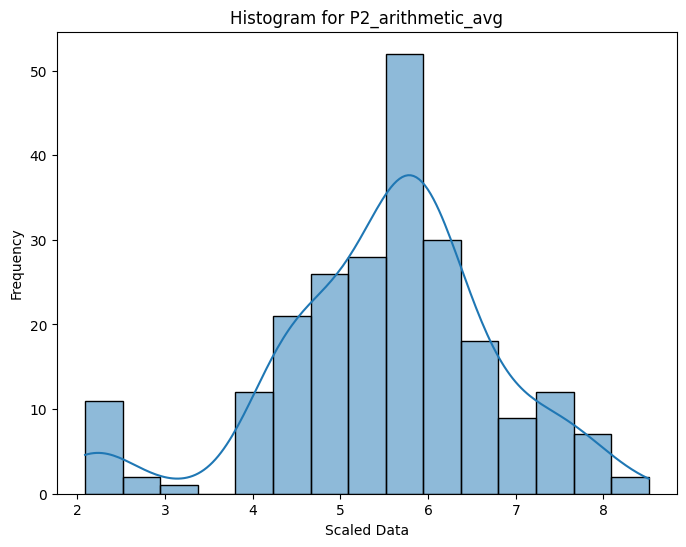

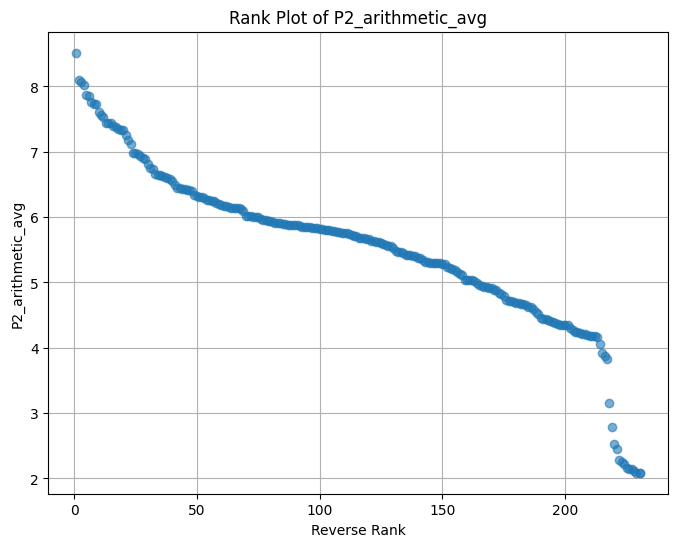

Processed data saved to /content/drive/MyDrive/CCRI_results_misc/P2_Merged_Normalized_avg.csv


In [16]:
# Define source and destination folder paths
source_folder = "/content/drive/MyDrive/p2_vulnerability/"
destination_folder = "/content/drive/MyDrive/CCRI_results_misc/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

# List of variables to reverse normalize
reverse_columns = [
    'P2_LSCED',
    'P2_Birth_Attendant_Y15T19',
    'P2_ED_CR_L2',
    'P2_Immunization_DTP1',
    'P2_Immunization_DTP3',
    'P2_WASH_Drinking_Water',
    'P2_WASH_Sanitation',
    'P2_basic_hygiene',
    'P2_electricity_access',
    'P2_Social_Protection'
]

# Initialize an empty DataFrame for merged results
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    # Extract filename for column naming
    filename = os.path.basename(file).replace(".csv", "")

    if 'iso3' not in df.columns or 'value' not in df.columns:
        continue  # Skip files missing required columns
    # Normalize 'value' column
    df = df[['iso3', 'value']].dropna()

    df_min_max = pd.read_csv(os.path.join(destination_folder,'p2_min_max.csv'))

    df_min_max['filename'] = df_min_max['filename'].astype(str).str.strip()
    filename = str(filename).strip()

    min_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'min'].values[0]
    max_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'max'].values[0]

    # clip to min max
    df['value'] = np.clip(df['value'], min_trimmed, max_trimmed)
    current_min = df['value'].min()
    current_max = df['value'].max()

    # Normalize using final min/max
    df['value_normalized'] = 10 * (df['value'] - current_min) / (current_max - current_min)
    df['min'] = min_trimmed
    df['max'] = max_trimmed


    # Reverse normalization for specific columns
    if filename in reverse_columns:
        df['value_normalized'] = 10 - df['value_normalized']  # Reverse normalize

    # Rename column
    df.rename(columns={'value_normalized': filename + '_value_normalized'}, inplace=True)
    df.rename(columns={'min': filename + '_min'}, inplace=True)
    df.rename(columns={'max': filename + '_max'}, inplace=True)

    print(f"processed : {filename} | min: {min_trimmed} | max: {max_trimmed}" )

    # Merge with the main DataFrame (use suffixes to avoid column name conflicts)
    if merged_df.empty:
        merged_df = df[['iso3', filename + '_value_normalized', filename + '_min', filename + '_max']]
    else:
        merged_df = merged_df.merge(df[['iso3', filename + '_value_normalized', filename + '_min', filename + '_max']],
                                     on='iso3', how='left', suffixes=('', f'_{filename}'))

# Filter columns that end with '_value_normalized'
health_prefixes = ['P2_Immunization_DTP1', 'P2_Immunization_DTP3', 'P2_Birth_Attendant_Y15T19', 'P2_electricity_access']
health_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in health_prefixes)]
nutrition_prefixes = ['P2_Nutrition_Stunting_Modeled', 'P2_food_poverty']
nutrition_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in nutrition_prefixes)]
wash_prefixes = ['P2_WASH_Drinking_Water', 'P2_WASH_Sanitation', 'P2_basic_hygiene']
wash_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in wash_prefixes)]
education_prefixes = ['P2_LSCED', 'P2_ED_CR_L2', 'P2_Learning_Poverty']
education_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in education_prefixes)]
protection_prefixes = ['P2_PT_Labor', 'P2_Child_Marriage']
protection_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in protection_prefixes)]
poverty_prefixes = ['P2_Child_poverty', 'P2_Social_Protection']
poverty_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in poverty_prefixes)]
survival_prefixes = ['P2_Child_Mortality']
survival_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in poverty_prefixes)]

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=RuntimeWarning)
  health_avg = merged_df[health_columns].apply(np.nanmean, axis=1)
  nutrition_avg = merged_df[nutrition_columns].apply(np.nanmean, axis=1)
  wash_avg = merged_df[wash_columns].apply(np.nanmean, axis=1)
  education_avg = merged_df[education_columns].apply(np.nanmean, axis=1)
  protection_avg = merged_df[protection_columns].apply(np.nanmean, axis=1)
  poverty_avg = merged_df[poverty_columns].apply(np.nanmean, axis=1)
  survival_avg = merged_df[survival_columns].apply(np.nanmean, axis=1)

# Combine all into a DataFrame
domains_df = pd.DataFrame({
    'health': health_avg,
    'nutrition': nutrition_avg,
    'wash': wash_avg,
    'education': education_avg,
    'protection': protection_avg,
    'poverty': poverty_avg,
    'survival': survival_avg
})

scaler = MinMaxScaler(feature_range=(0, 10))
domains_scaled = pd.DataFrame(
    scaler.fit_transform(domains_df),
    columns=domains_df.columns,
    index=domains_df.index
)


# Compute the average across all '_value_normalized' columns (ignoring NaNs)
merged_df["P2_arithmetic_avg"] = domains_scaled.apply(np.nanmean, axis=1)

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['P2_arithmetic_avg'], kde=True)
plt.title(f"Histogram for P2_arithmetic_avg")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

# Compute ranks in reverse order
merged_df['rank_reverse'] = merged_df['P2_arithmetic_avg'].rank(method='average', ascending=False)
plt.figure(figsize=(8, 6))
plt.plot(merged_df['rank_reverse'], merged_df['P2_arithmetic_avg'], marker='o', linestyle='', alpha=0.6)
plt.xlabel("Reverse Rank")
plt.ylabel("P2_arithmetic_avg")
plt.title(f"Rank Plot of P2_arithmetic_avg")
plt.grid(True)
plt.show()

# clip to min max
merged_df['P2_arithmetic_avg'] = np.clip(merged_df['P2_arithmetic_avg'], 4, 8)
current_min = merged_df['P2_arithmetic_avg'].min()
current_max = merged_df['P2_arithmetic_avg'].max()

# Normalize using final min/max
merged_df['P2_arithmetic_avg'] = 10 * (merged_df['P2_arithmetic_avg'] - current_min) / (current_max - current_min)



# Save the final merged dataset
output_file = os.path.join(destination_folder, "P2_Merged_Normalized_avg.csv")
merged_df.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")


Alt. take arithmetic average of all p2 variables at once

processed : P2_WASH_Drinking_Water | min: 35 | max: 100
processed : P2_WASH_Sanitation | min: 10 | max: 100
processed : P2_LSCED | min: 1 | max: 70
processed : P2_Nutrition_Stunting_Modeled | min: 1 | max: 50
processed : P2_Child_Mortality | min: 1 | max: 30
processed : P2_Immunization_DTP1 | min: 45 | max: 98
processed : P2_Immunization_DTP3 | min: 40 | max: 98
processed : P2_PT_Labor | min: 1 | max: 40
processed : P2_Learning_Poverty | min: 3 | max: 98
processed : P2_ED_CR_L2 | min: 1 | max: 100
processed : P2_Birth_Attendant_Y15T19 | min: 25 | max: 100
processed : P2_Child_poverty | min: 3 | max: 83
processed : P2_Child_Marriage | min: 0 | max: 76
processed : P2_food_poverty | min: 0 | max: 70
processed : P2_Social_Protection | min: 0 | max: 100
processed : P2_basic_hygiene | min: 4 | max: 100
processed : P2_electricity_access | min: 10 | max: 100


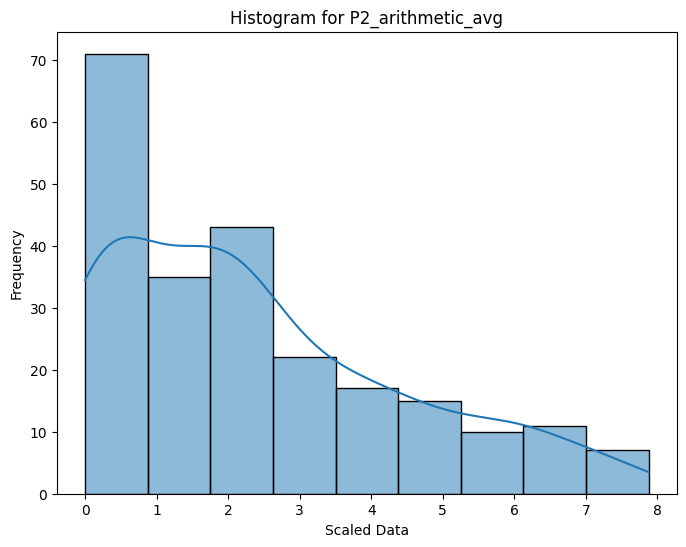

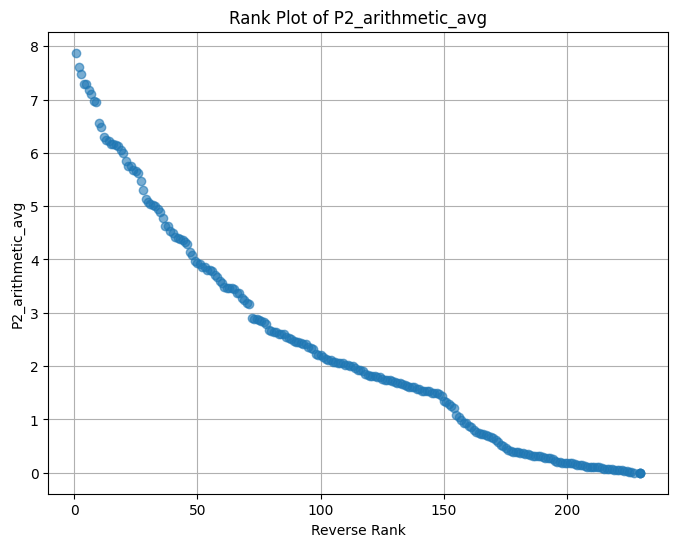

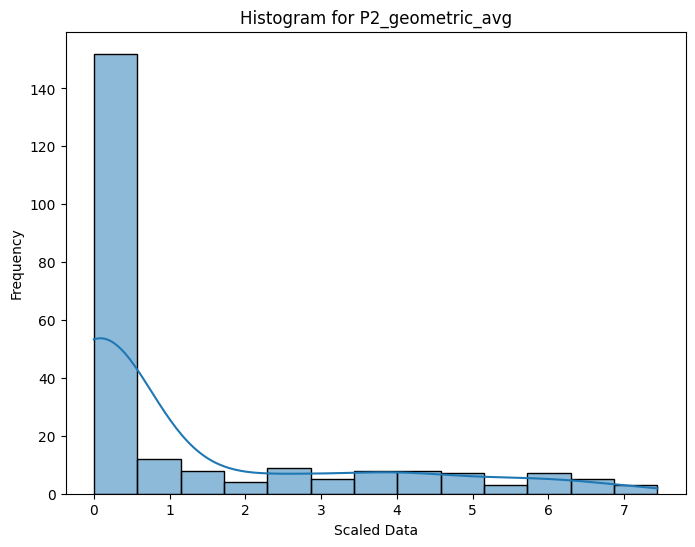

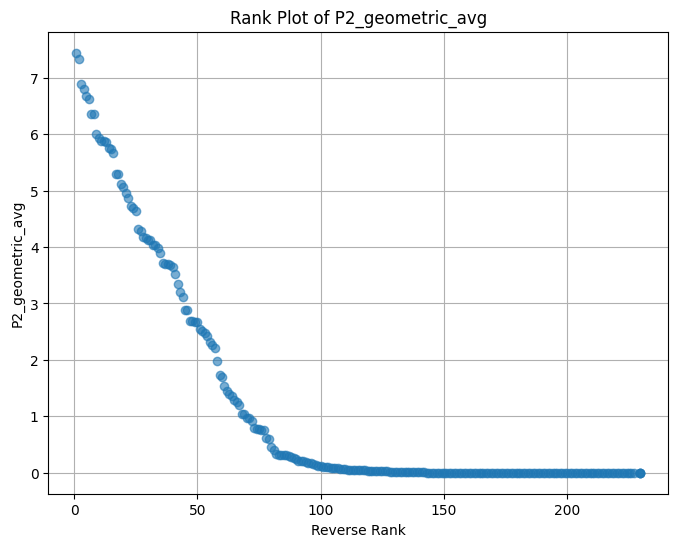

Processed data saved to /content/drive/MyDrive/CCRI_results_misc/P2_Merged_Normalized_avg.csv


In [ ]:
# Define source and destination folder paths
source_folder = "/content/drive/MyDrive/p2_vulnerability/"
destination_folder = "/content/drive/MyDrive/CCRI_results_misc/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

# List of variables to reverse normalize
reverse_columns = [
    'P2_LSCED',
    'P2_Birth_Attendant_Y15T19',
    'P2_ED_CR_L2',
    'P2_Immunization_DTP1',
    'P2_Immunization_DTP3',
    'P2_WASH_Drinking_Water',
    'P2_WASH_Sanitation',
    'P2_basic_hygiene',
    'P2_electricity_access',
    'P2_Social_Protection'
]

# Initialize an empty DataFrame for merged results
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    # Extract filename for column naming
    filename = os.path.basename(file).replace(".csv", "")

    if 'iso3' not in df.columns or 'value' not in df.columns:
        continue  # Skip files missing required columns
    # Normalize 'value' column
    df = df[['iso3', 'value']].dropna()

    df_min_max = pd.read_csv('/content/drive/MyDrive/CCRI_results_misc/p2_min_max.csv')

    df_min_max['filename'] = df_min_max['filename'].astype(str).str.strip()
    filename = str(filename).strip()

    min_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'min'].values[0]
    max_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'max'].values[0]

    # clip to min max
    df['value'] = np.clip(df['value'], min_trimmed, max_trimmed)
    current_min = df['value'].min()
    current_max = df['value'].max()

    # Normalize using final min/max
    df['value_normalized'] = 10 * (df['value'] - current_min) / (current_max - current_min)
    df['min'] = min_trimmed
    df['max'] = max_trimmed


    # Reverse normalization for specific columns
    if filename in reverse_columns:
        df['value_normalized'] = 10 - df['value_normalized']  # Reverse normalize

    # Rename column
    df.rename(columns={'value_normalized': filename + '_value_normalized'}, inplace=True)
    df.rename(columns={'min': filename + '_min'}, inplace=True)
    df.rename(columns={'max': filename + '_max'}, inplace=True)

    print(f"processed : {filename} | min: {min_trimmed} | max: {max_trimmed}" )

    # Merge with the main DataFrame (use suffixes to avoid column name conflicts)
    if merged_df.empty:
        merged_df = df[['iso3', filename + '_value_normalized', filename + '_min', filename + '_max']]
    else:
        merged_df = merged_df.merge(df[['iso3', filename + '_value_normalized', filename + '_min', filename + '_max']],
                                     on='iso3', how='left', suffixes=('', f'_{filename}'))

# Filter columns that end with '_value_normalized'
pillar2_columns = [col for col in merged_df.columns if col.endswith('_value_normalized')]

# Compute the average across all '_value_normalized' columns (ignoring NaNs)
merged_df["P2_arithmetic_avg"] = merged_df[pillar2_columns].apply(np.nanmean, axis=1)

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['P2_arithmetic_avg'], kde=True)
plt.title(f"Histogram for P2_arithmetic_avg")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

# Compute ranks in reverse order
merged_df['rank_reverse'] = merged_df['P2_arithmetic_avg'].rank(method='average', ascending=False)
plt.figure(figsize=(8, 6))
plt.plot(merged_df['rank_reverse'], merged_df['P2_arithmetic_avg'], marker='o', linestyle='', alpha=0.6)
plt.xlabel("Reverse Rank")
plt.ylabel("P2_arithmetic_avg")
plt.title(f"Rank Plot of P2_arithmetic_avg")
plt.grid(True)
plt.show()

# clip to min max
merged_df['P2_arithmetic_avg'] = np.clip(merged_df['P2_arithmetic_avg'], 0, 3)
current_min = merged_df['P2_arithmetic_avg'].min()
current_max = merged_df['P2_arithmetic_avg'].max()

# Normalize using final min/max
merged_df['P2_arithmetic_avg'] = 10 * (merged_df['P2_arithmetic_avg'] - current_min) / (current_max - current_min)

# Calculate geometric average
merged_df["P2_geometric_avg"] = merged_df[pillar2_columns].apply(
    lambda x: gmean(x[~np.isnan(x)] + 1e-10) if np.any(~np.isnan(x)) else np.nan, axis=1
)

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['P2_geometric_avg'], kde=True)
plt.title(f"Histogram for P2_geometric_avg")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

# Compute ranks in reverse order
merged_df['rank_reverse'] = merged_df['P2_geometric_avg'].rank(method='average', ascending=False)
plt.figure(figsize=(8, 6))
plt.plot(merged_df['rank_reverse'], merged_df['P2_geometric_avg'], marker='o', linestyle='', alpha=0.6)
plt.xlabel("Reverse Rank")
plt.ylabel("P2_geometric_avg")
plt.title(f"Rank Plot of P2_geometric_avg")
plt.grid(True)
plt.show()

merged_df['P2_geometric_avg'] = np.clip(merged_df['P2_geometric_avg'], 0, 0.5)
current_min = merged_df['P2_geometric_avg'].min()
current_max = merged_df['P2_geometric_avg'].max()

# Normalize using final min/max
merged_df['P2_geometric_avg'] = 10 * (merged_df['P2_geometric_avg'] - current_min) / (current_max - current_min)

# Save the final merged dataset
output_file = os.path.join(destination_folder, "P2_Merged_Normalized_avg.csv")
merged_df.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")
